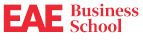

**Notebook - TFM_G5_Churn Prediction**

**Ahinoa Salvadó Rivas
Joseph Peter Wilde
Aina Lluís Huelmo**


---

**PYTHON CODE FMT**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

Import data by transforming a .parquet file to a dataframe and a .csv file

In [3]:
import pandas as pd

data = pd.read_parquet('FMT_dataset.snappy.parquet')
data.to_csv('fmt_data.csv', index=False)

In [4]:
data['event_datetime'] = pd.to_datetime(data['event_datetime'])

cutoff_date = data['event_datetime'].max() - pd.Timedelta(days=60)

data = data[~(
    (data['repeated_purchase_in_60d'] == False) &
    (data['event_datetime'] >= cutoff_date)
)]

# Display new shape of the dataframe
print(data.shape)

(21438, 27)


Dimensions of the dataset:

In [5]:
print("Dimensions of the data set:", data.shape)

Dimensions of the data set: (21438, 27)


In [6]:
data.head()

,anonymous_id,product_ids,session_id,total,utm_source,event_datetime,cust_id,true_sess_id,event_count_cumulative,unique_session_count_cumulative_y,...,fb_session,email_session,session_duration_seconds,product_id_count,cumulative_product_id_count,repeated_purchase_in_60d,Weekend_Purchase,Mac_Purchase,iPhone_Purchase,mobile_purchase
0,aa62fb2e-d302-4c72-973c-87ebf27f9637,"[79036832, 79072779]",0a185ee4-49c5-4362-8c46-0e6df8c85edf,33400.0,None,2024-02-02 03:50:47.191000+00:00,1,3765.0,37,286,...,False,False,3534.163,2,2,True,0,False,False,False
1,aa62fb2e-d302-4c72-973c-87ebf27f9637,[89022474],8c91ea42-419c-4e80-8b17-642b2168b2fd,17700.0,None,2024-02-05 13:31:52.777000+00:00,1,55058.0,78,286,...,False,False,1703.559,1,3,True,0,False,False,False
2,aa62fb2e-d302-4c72-973c-87ebf27f9637,[89030714],b770ad0e-5284-49c4-a46c-95200a5bb76a,17600.0,None,2024-02-07 04:08:27.320000+00:00,1,71401.0,100,286,...,False,False,1431.259,1,4,True,0,False,False,False
3,aa62fb2e-d302-4c72-973c-87ebf27f9637,[89029688],b770ad0e-5284-49c4-a46c-95200a5bb76a,16200.0,None,2024-02-07 04:28:36.524000+00:00,1,71401.0,114,286,...,False,False,1431.259,1,5,True,0,False,False,False
4,aa62fb2e-d302-4c72-973c-87ebf27f9637,[89016855],eb68ac48-1e75-41b7-a7eb-f34d0ff39fdf,11200.0,None,2024-02-10 23:41:08.493000+00:00,1,91652.0,123,286,...,False,False,980.837,1,6,True,1,False,False,False


Remove variables:

In [7]:
variables_to_delete = ['product_ids', 'utm_source', 'day_type','event_datetime','product_ids','anonymous_id', 'session_id','cumulative_abandoned_carts_x','cumulative_abandoned_carts_y','cust_id','true_sess_id']
data = data.drop(columns=variables_to_delete, errors='ignore')

Changing variable names:

In [8]:
data.rename(columns={'total': 'purchase_value'}, inplace=True)
data.rename(columns={'Mobile_Purchase': 'mobile_purchase'}, inplace=True)

data.rename(columns={'discounted_product_proportion': 'purchase_discount%'}, inplace=True)
data.rename(columns={'repeat_product_proportion': 'purchase_repeat_product%'}, inplace=True)
data.rename(columns={'session_duration_seconds': 'purchase_session_duration'}, inplace=True)
data.rename(columns={'session_event_count': 'purchase_session_event_count'}, inplace=True)
data.rename(columns={'event_count_cumulative': 'user_lifetime_event_count'}, inplace=True)


data.rename(columns={'Mac_Purchase': 'mac_purchase'}, inplace=True)
data.rename(columns={'iPhone_Purchase': 'iphone_purchase'}, inplace=True)
data.rename(columns={'Weekend_Purchase': 'weekend_purchase'}, inplace=True)
data.rename(columns={'unique_session_count_cumulative': 'user_lifetime_session_count'}, inplace=True)
data.rename(columns={'purchase_count_cumulative': 'user_lifetime_purchase_count'}, inplace=True)

data.rename(columns={'cumulative_unique_product_viewed_count': 'user_lifetime_products_viewed'}, inplace=True)

Treating missing values

In [9]:
missing_values = data.isna().sum()

print("Number of missing values for each variable:")
print(missing_values)

Number of missing values for each variable:
purchase_value                          0
user_lifetime_event_count               0
unique_session_count_cumulative_y       0
user_lifetime_purchase_count            0
days_since_previous_purchase         5963
q1_purchase                             0
q2_purchase                             0
q3_purchase                             0
mean_discounted_proportion              0
purchase_repeat_product%                0
fb_session                              0
email_session                           0
purchase_session_duration               0
product_id_count                        0
cumulative_product_id_count             0
repeated_purchase_in_60d                0
weekend_purchase                        0
mac_purchase                            0
iphone_purchase                         0
mobile_purchase                         0
dtype: int64


NULL values in days_since_previous_purchase have missing values because it's their first purchase. This will be substituted by 999.

In [10]:
data['days_since_previous_purchase'].fillna(999, inplace=True)

<ipython-input-10-2621242679>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['days_since_previous_purchase'].fillna(999, inplace=True)


In [11]:
missing_values = data.isna().sum()

print("Number of missing values for each variable:")
print(missing_values)

Number of missing values for each variable:
purchase_value                       0
user_lifetime_event_count            0
unique_session_count_cumulative_y    0
user_lifetime_purchase_count         0
days_since_previous_purchase         0
q1_purchase                          0
q2_purchase                          0
q3_purchase                          0
mean_discounted_proportion           0
purchase_repeat_product%             0
fb_session                           0
email_session                        0
purchase_session_duration            0
product_id_count                     0
cumulative_product_id_count          0
repeated_purchase_in_60d             0
weekend_purchase                     0
mac_purchase                         0
iphone_purchase                      0
mobile_purchase                      0
dtype: int64


A list for each variable type

In [12]:
categorical_variables = ['email_session', 'mobile_purchase', 'mac_purchase',
    'iphone_purchase',
    'weekend_purchase','repeated_purchase_in_60d','q1_purchase','q2_purchase','q3_purchase']

numeric_variables = [
    'purchase_value','unique_session_count_cumulative_y','mean_discounted_proportion','purchase_repeat_product%','purchase_session_duration',
    'days_since_previous_purchase', 'user_lifetime_event_count', 'user_lifetime_purchase_count', 'cumulative_product_id_count'
]

data[numeric_variables] = data[numeric_variables].astype(int)


# **EXPLORATORY DATA ANALYSIS**

In [13]:
data.dtypes

,0
purchase_value,int64
user_lifetime_event_count,int64
unique_session_count_cumulative_y,int64
user_lifetime_purchase_count,int64
days_since_previous_purchase,int64
q1_purchase,bool
q2_purchase,bool
q3_purchase,bool
mean_discounted_proportion,int64
purchase_repeat_product%,int64


In [ ]:
data.describe()

In [14]:
column_names = data.columns

print(column_names)

Index(['purchase_value', 'user_lifetime_event_count',
       'unique_session_count_cumulative_y', 'user_lifetime_purchase_count',
       'days_since_previous_purchase', 'q1_purchase', 'q2_purchase',
       'q3_purchase', 'mean_discounted_proportion', 'purchase_repeat_product%',
       'fb_session', 'email_session', 'purchase_session_duration',
       'product_id_count', 'cumulative_product_id_count',
       'repeated_purchase_in_60d', 'weekend_purchase', 'mac_purchase',
       'iphone_purchase', 'mobile_purchase'],
      dtype='object')


**Univariate exploratory data analysis**

Numerical variables:

count    2.143800e+04
mean     1.262948e+05
std      1.075946e+05
min      5.000000e+03
25%      5.620000e+04
50%      1.018000e+05
75%      1.648000e+05
max      5.042050e+06
Name: purchase_value, dtype: float64


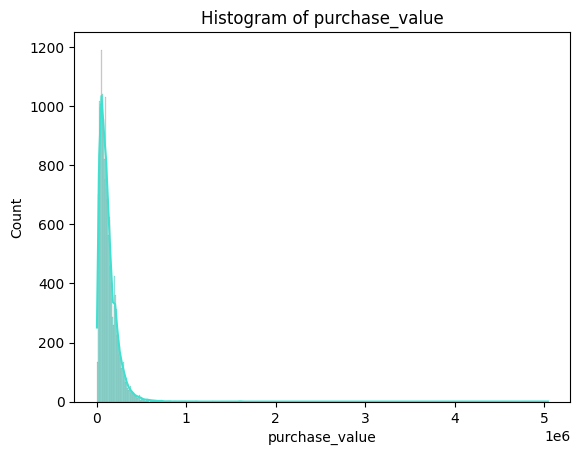

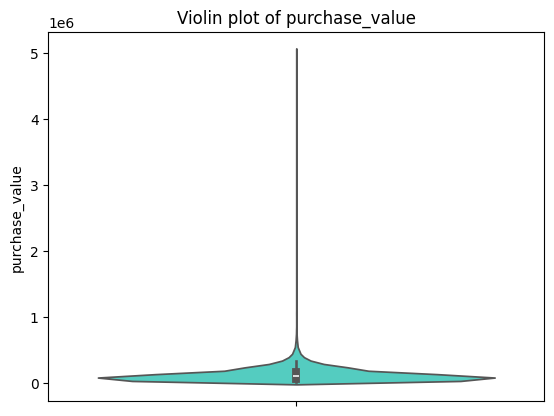

count    21438.000000
mean        63.597211
std        108.758780
min          1.000000
25%          8.000000
50%         24.000000
75%         69.000000
max       1092.000000
Name: unique_session_count_cumulative_y, dtype: float64


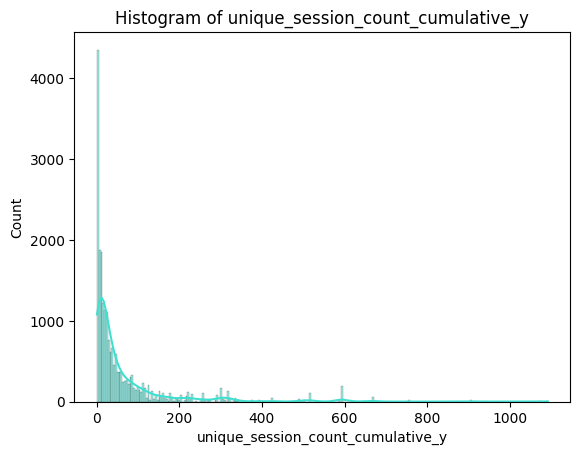

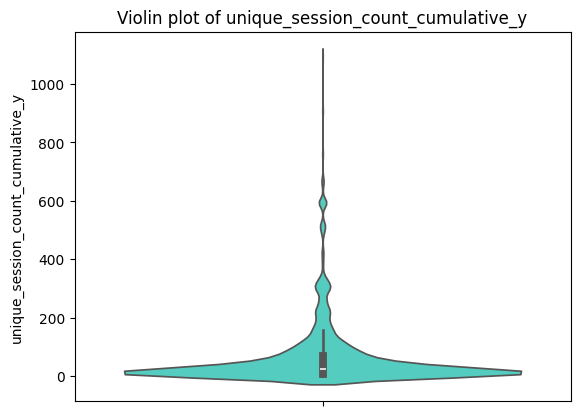

count    21438.000000
mean         0.057608
std          0.233006
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: mean_discounted_proportion, dtype: float64


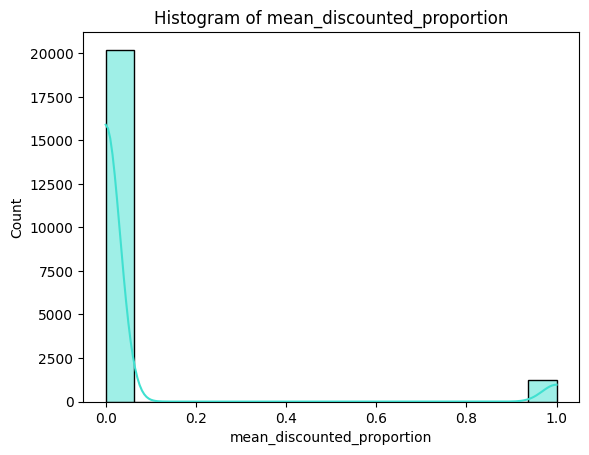

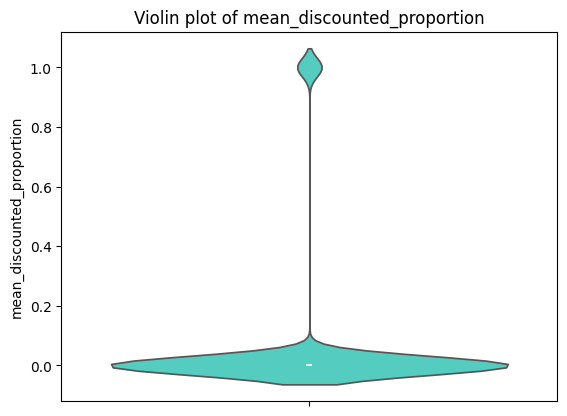

count    21438.000000
mean         0.208788
std          0.406452
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: purchase_repeat_product%, dtype: float64


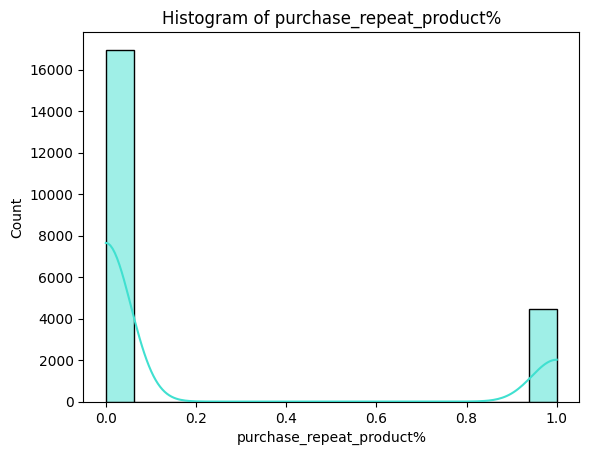

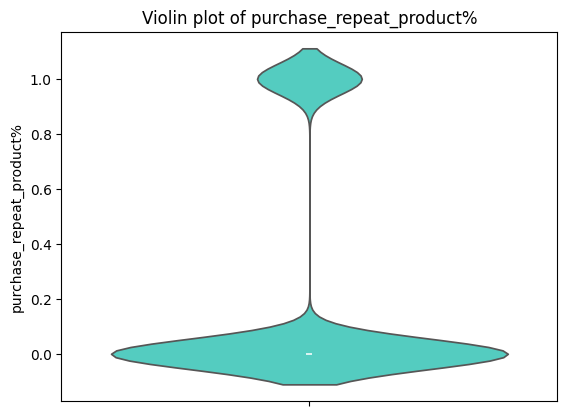

count     21438.000000
mean       1200.930637
std        2076.420868
min           0.000000
25%         327.000000
50%         730.000000
75%        1529.000000
max      108464.000000
Name: purchase_session_duration, dtype: float64


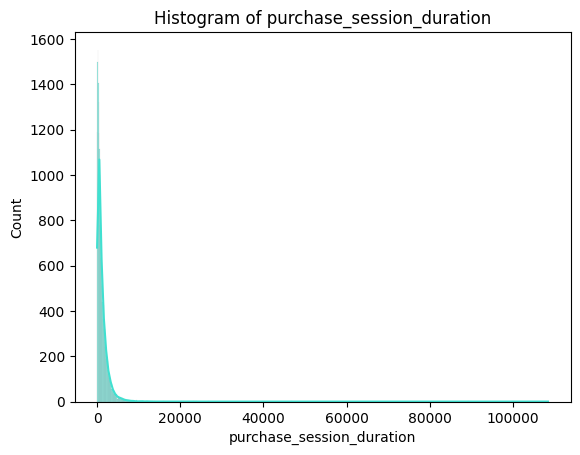

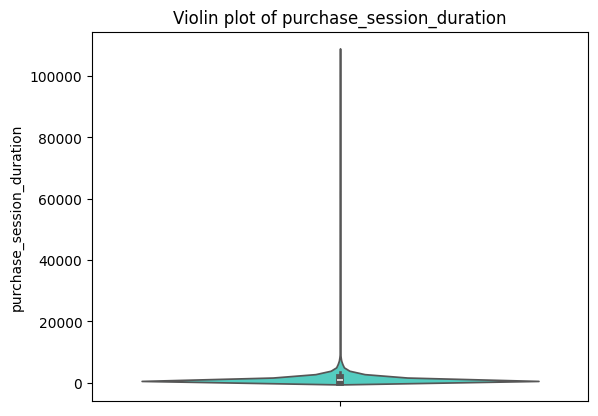

count    21438.000000
mean       300.297649
std        435.772390
min          0.000000
25%          7.000000
50%         27.000000
75%        999.000000
max        999.000000
Name: days_since_previous_purchase, dtype: float64


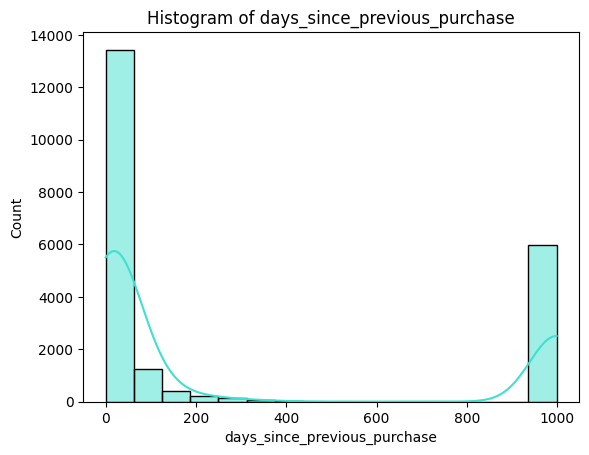

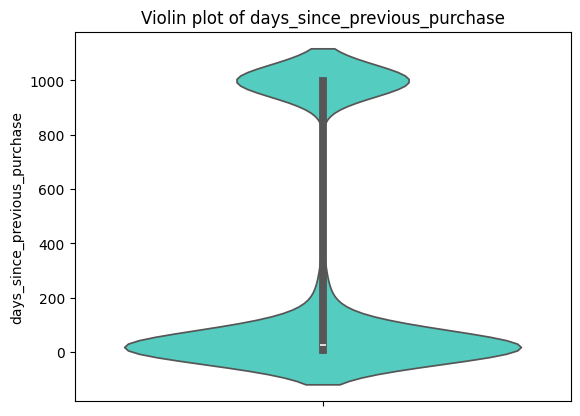

count    21438.000000
mean       255.442579
std        411.907880
min          2.000000
25%         29.000000
50%         98.000000
75%        290.000000
max       5375.000000
Name: user_lifetime_event_count, dtype: float64


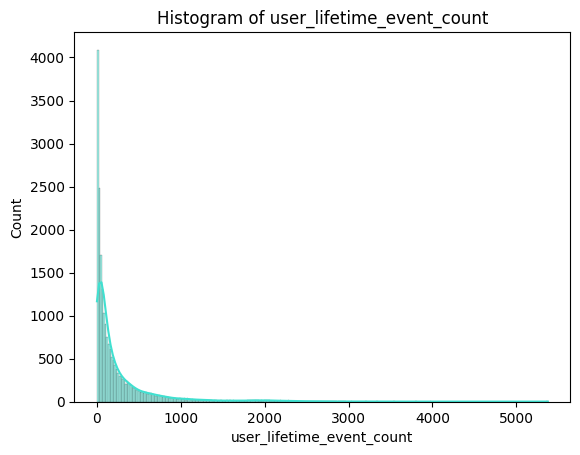

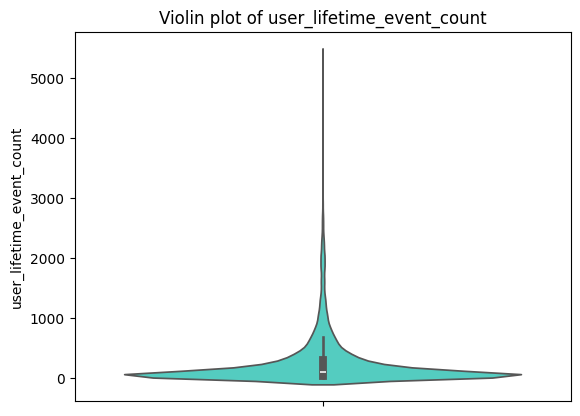

count    21438.000000
mean         9.174597
std         16.535488
min          1.000000
25%          1.000000
50%          4.000000
75%         10.000000
max        188.000000
Name: user_lifetime_purchase_count, dtype: float64


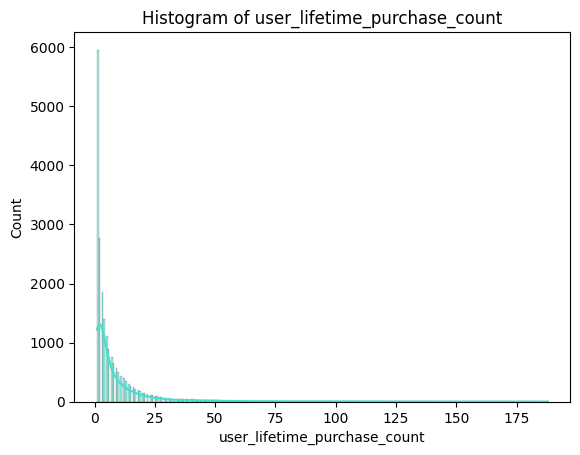

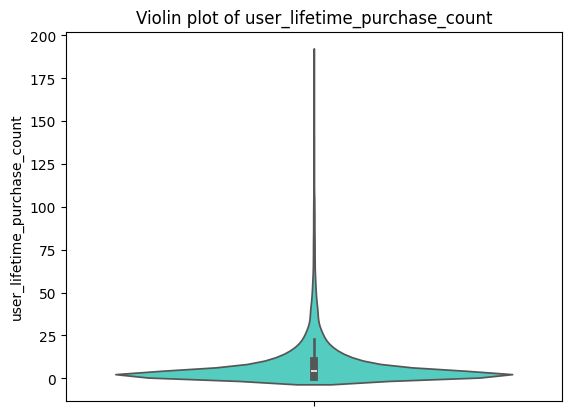

count    21438.000000
mean        14.901763
std         39.380699
min          1.000000
25%          3.000000
50%          6.000000
75%         12.000000
max        707.000000
Name: cumulative_product_id_count, dtype: float64


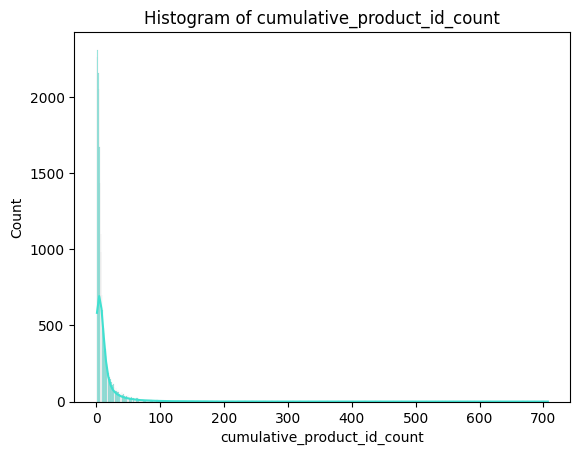

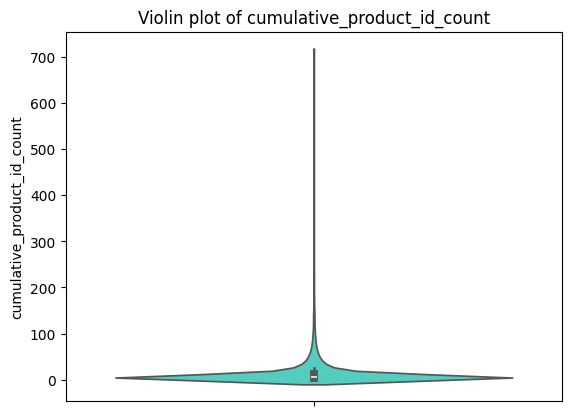

In [15]:
import seaborn as sns

for var in numeric_variables:
    print(data[var].describe())
    sns.histplot(data[var], kde=True, color="turquoise")
    plt.title(f"Histogram of {var}")
    plt.show()

    sns.violinplot(y=data[var], color="turquoise")
    plt.title(f"Violin plot of {var}")
    plt.show()

Discrete numerical variables


Descriptive stats for: purchase_value
count    2.143800e+04
mean     1.262948e+05
std      1.075946e+05
min      5.000000e+03
25%      5.620000e+04
50%      1.018000e+05
75%      1.648000e+05
max      5.042050e+06
Name: purchase_value, dtype: float64


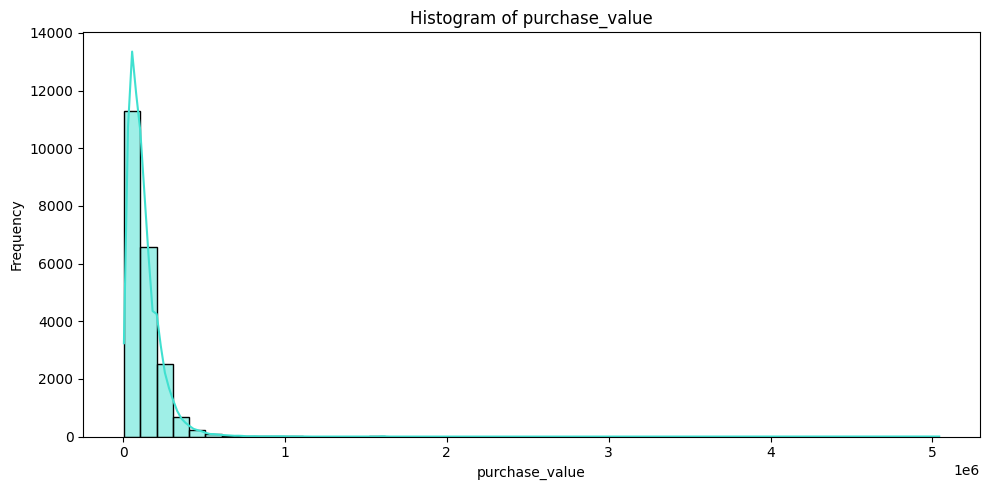

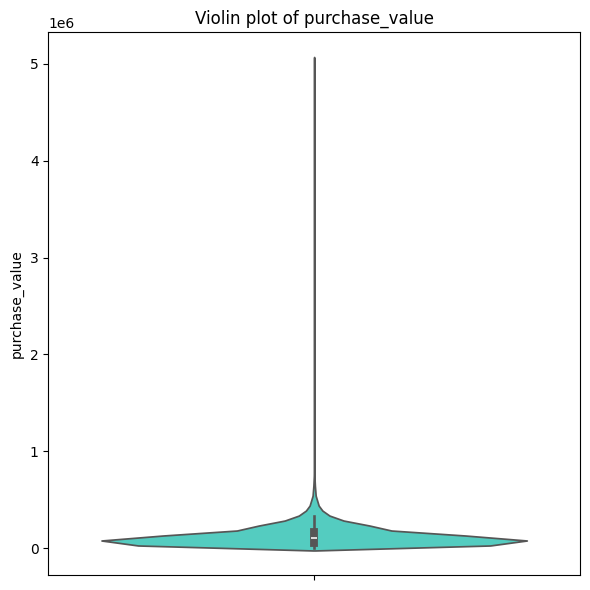


Descriptive stats for: unique_session_count_cumulative_y
count    21438.000000
mean        63.597211
std        108.758780
min          1.000000
25%          8.000000
50%         24.000000
75%         69.000000
max       1092.000000
Name: unique_session_count_cumulative_y, dtype: float64


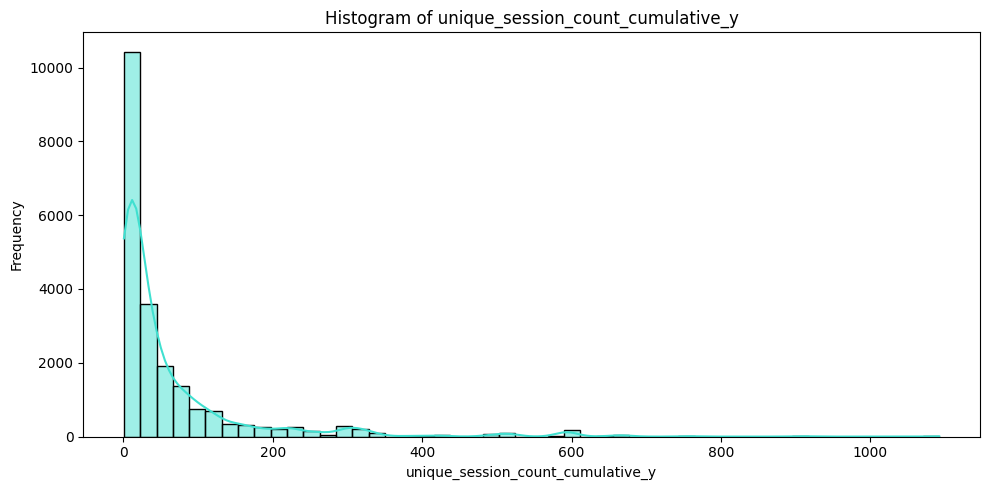

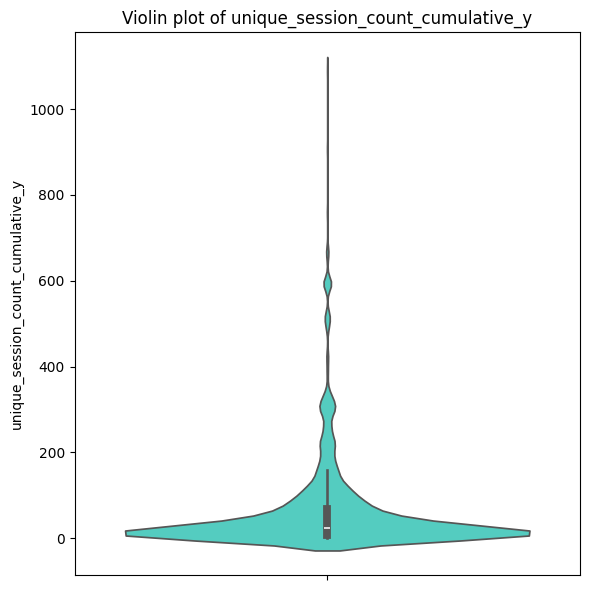


Descriptive stats for: mean_discounted_proportion
count    21438.000000
mean         0.057608
std          0.233006
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: mean_discounted_proportion, dtype: float64


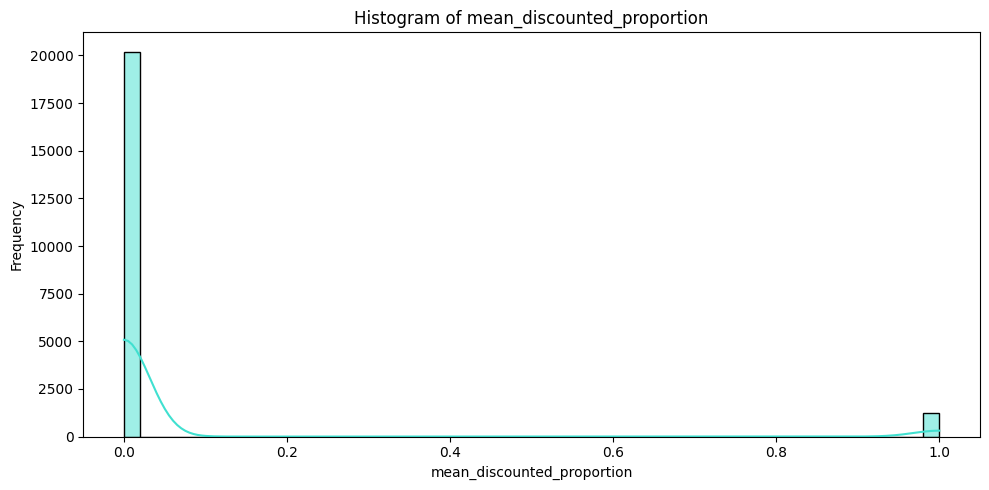

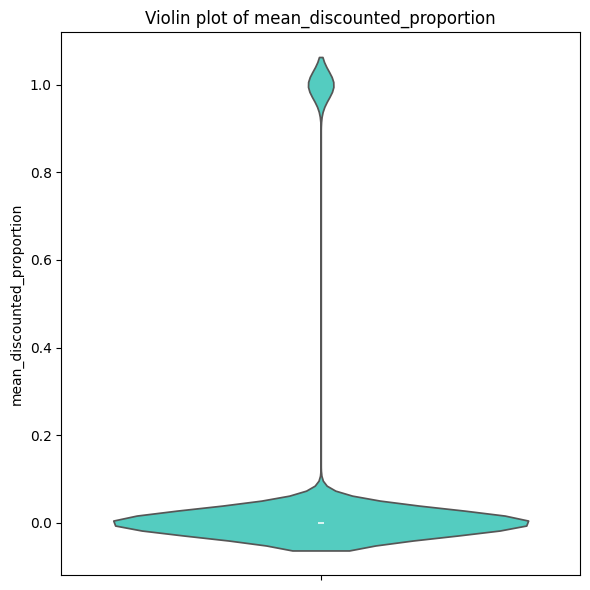


Descriptive stats for: purchase_repeat_product%
count    21438.000000
mean         0.208788
std          0.406452
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: purchase_repeat_product%, dtype: float64


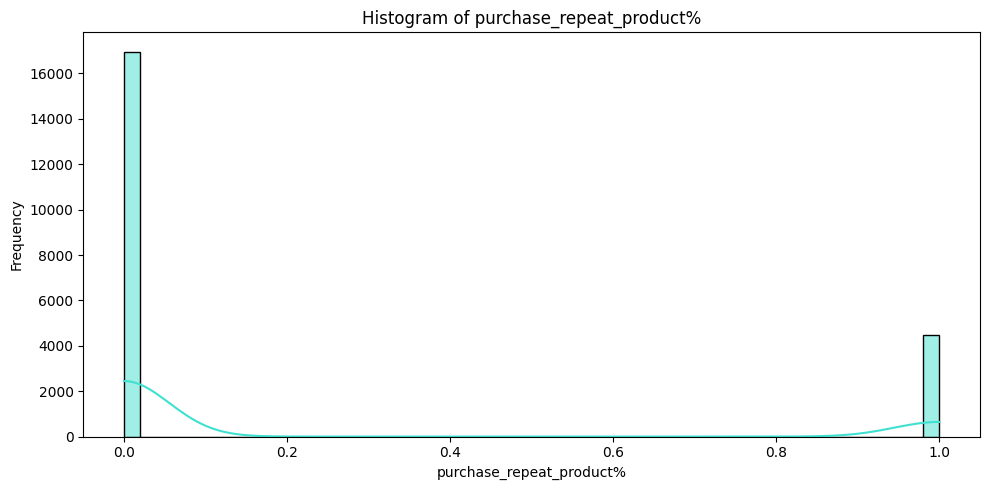

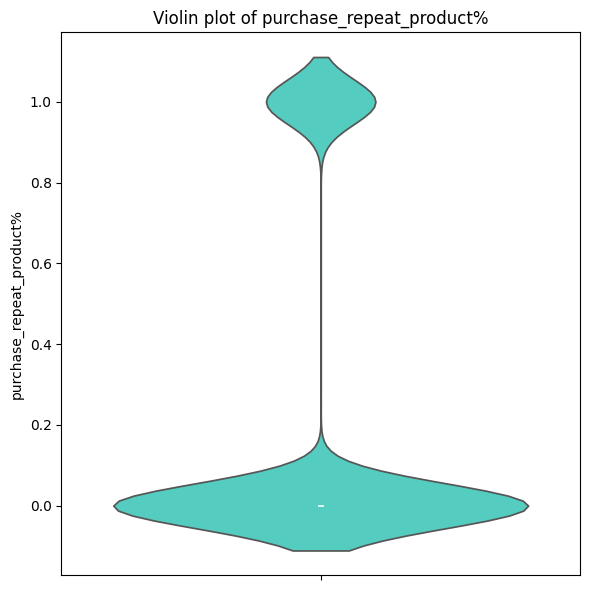


Descriptive stats for: purchase_session_duration
count     21438.000000
mean       1200.930637
std        2076.420868
min           0.000000
25%         327.000000
50%         730.000000
75%        1529.000000
max      108464.000000
Name: purchase_session_duration, dtype: float64


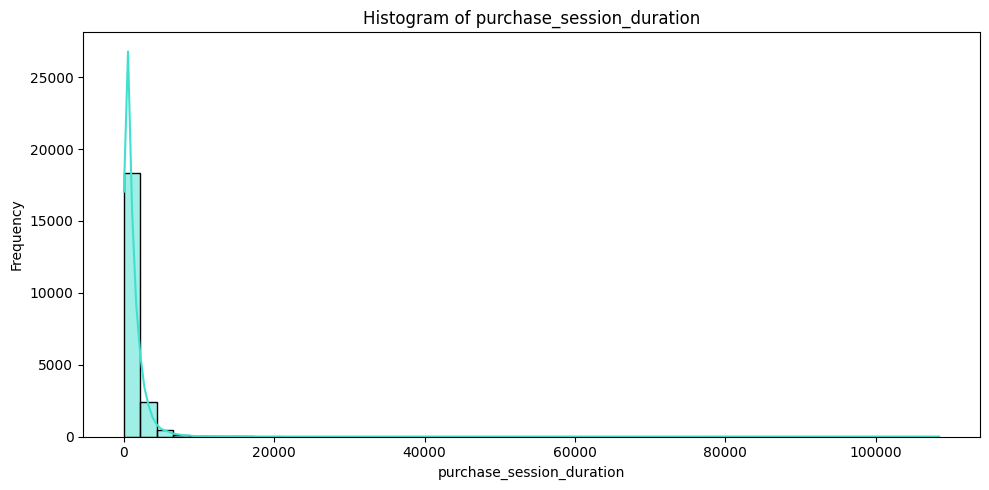

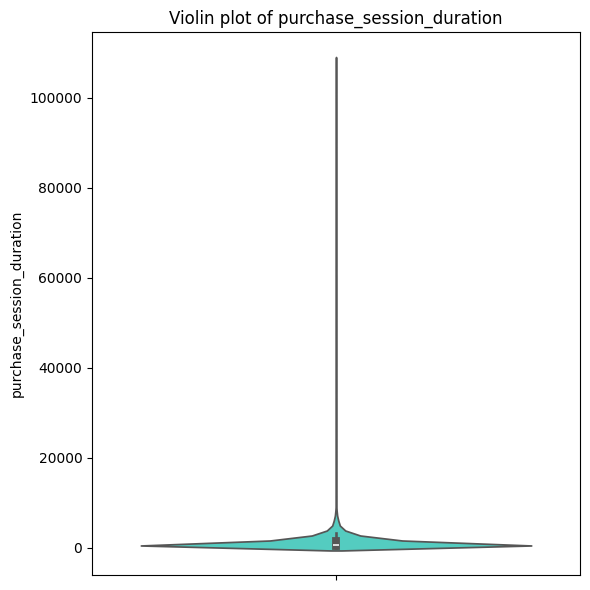


Descriptive stats for: days_since_previous_purchase
count    21438.000000
mean       300.297649
std        435.772390
min          0.000000
25%          7.000000
50%         27.000000
75%        999.000000
max        999.000000
Name: days_since_previous_purchase, dtype: float64


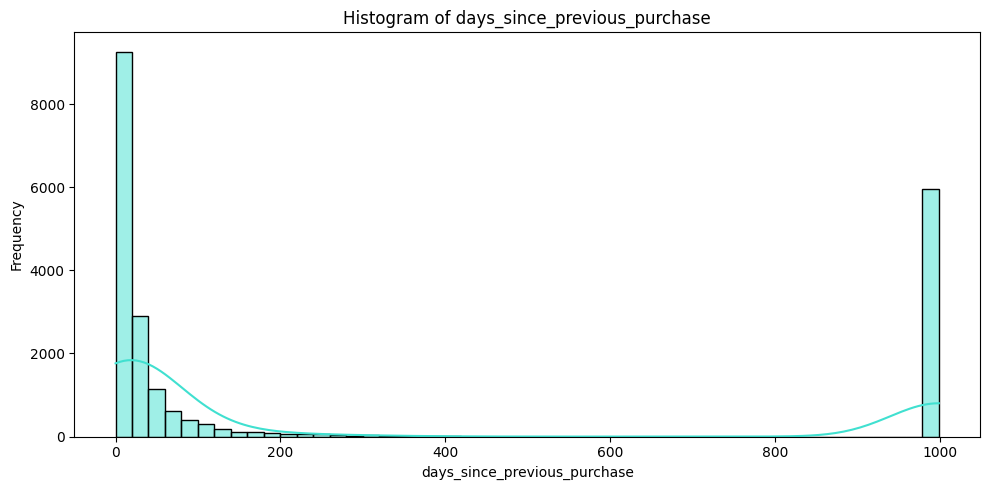

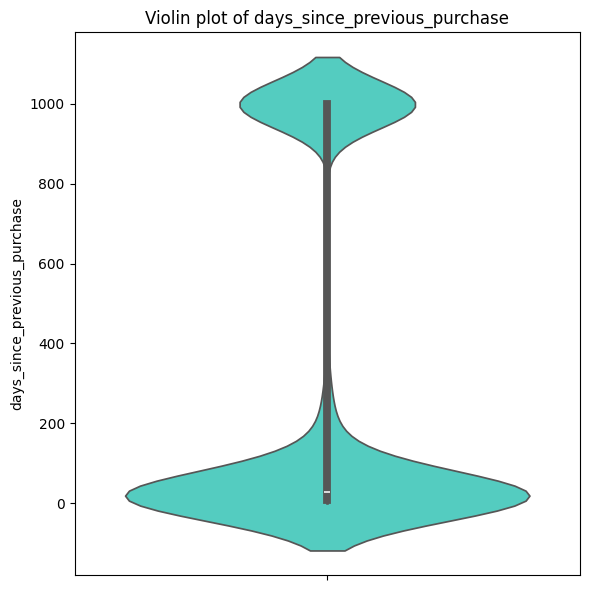


Descriptive stats for: user_lifetime_event_count
count    21438.000000
mean       255.442579
std        411.907880
min          2.000000
25%         29.000000
50%         98.000000
75%        290.000000
max       5375.000000
Name: user_lifetime_event_count, dtype: float64


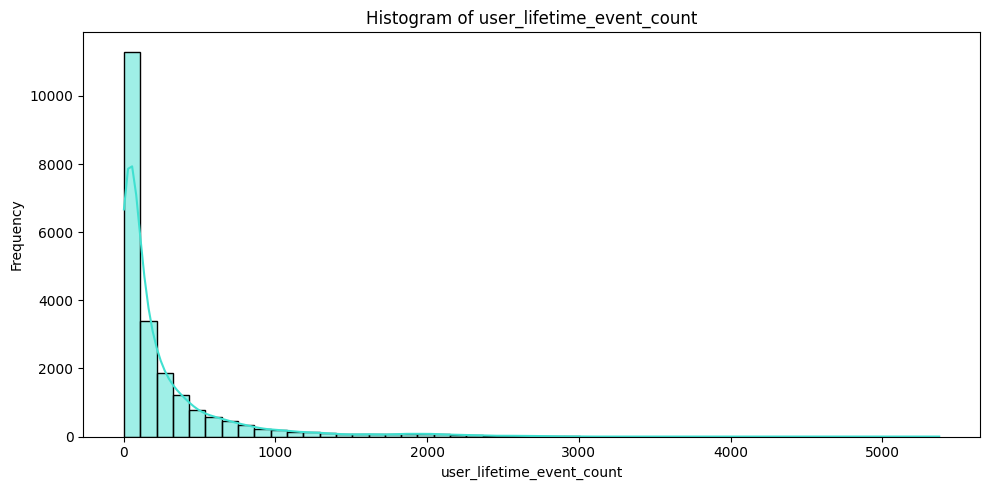

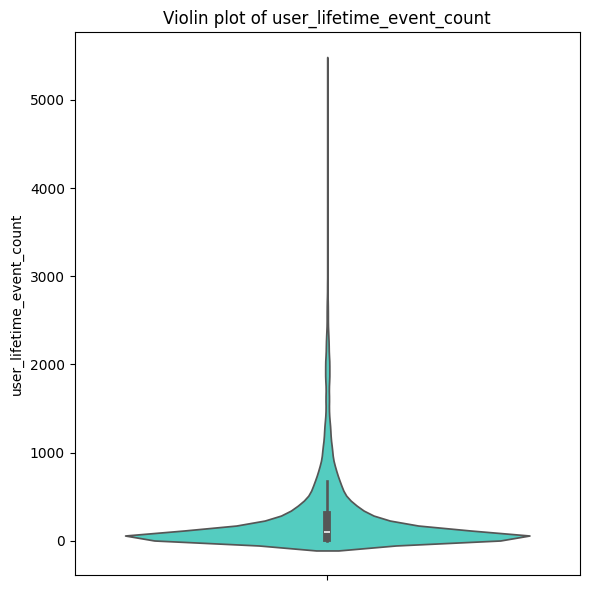


Descriptive stats for: user_lifetime_purchase_count
count    21438.000000
mean         9.174597
std         16.535488
min          1.000000
25%          1.000000
50%          4.000000
75%         10.000000
max        188.000000
Name: user_lifetime_purchase_count, dtype: float64


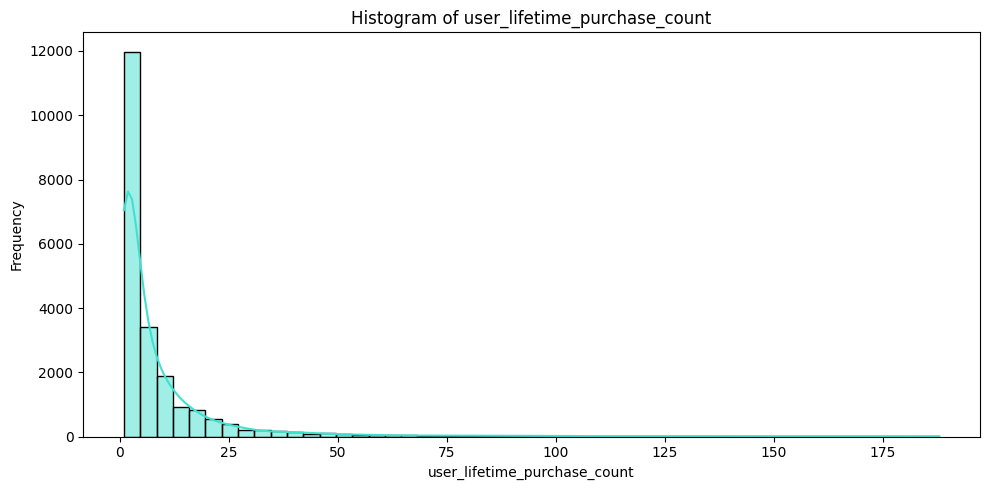

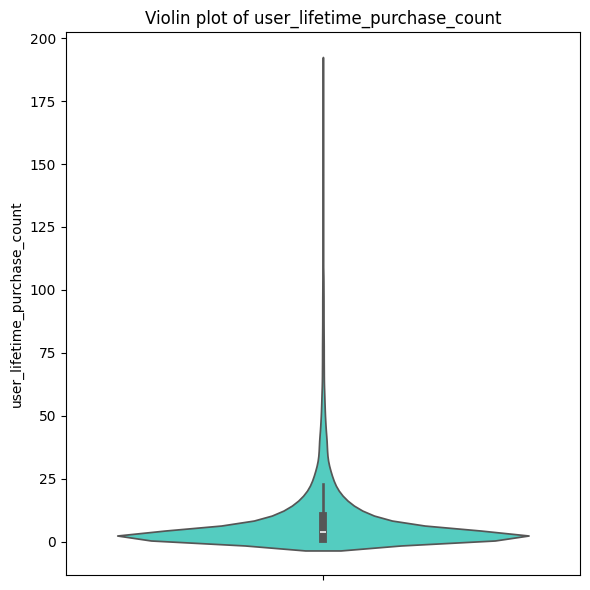


Descriptive stats for: cumulative_product_id_count
count    21438.000000
mean        14.901763
std         39.380699
min          1.000000
25%          3.000000
50%          6.000000
75%         12.000000
max        707.000000
Name: cumulative_product_id_count, dtype: float64


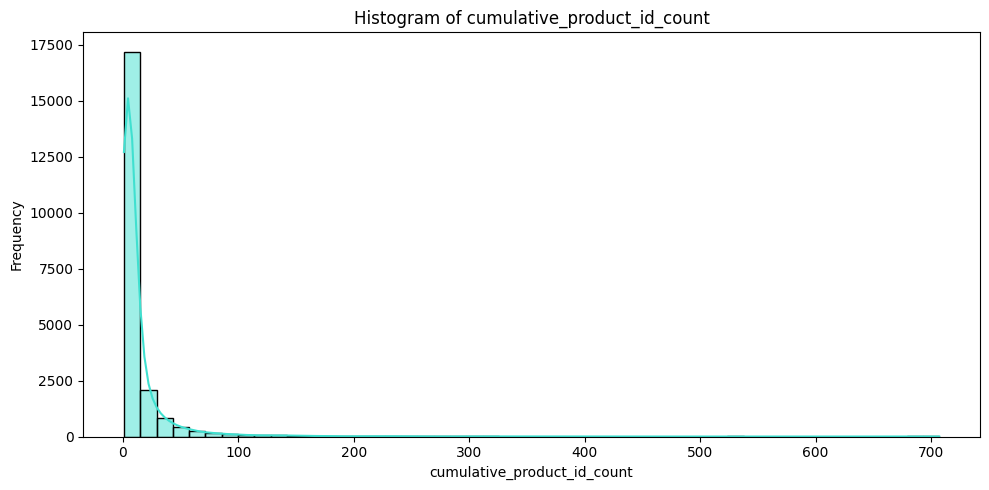

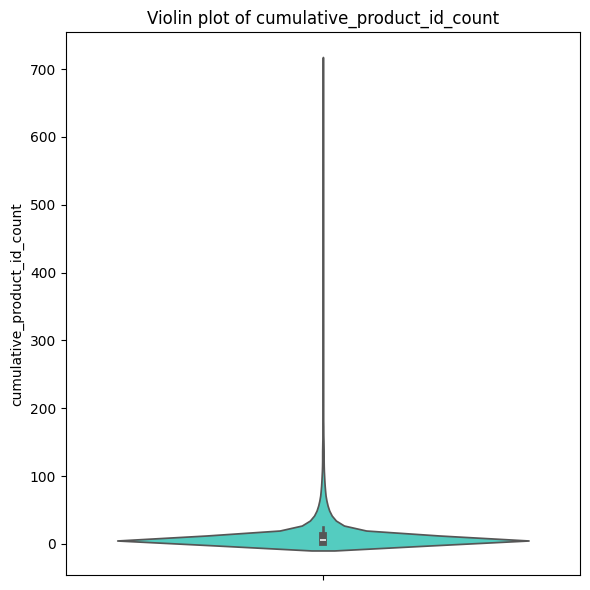

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

for var in numeric_variables:
    print(f"\nDescriptive stats for: {var}")
    print(data[var].describe())

    # Histograma
    plt.figure(figsize=(10, 5), facecolor='white')
    ax = plt.gca()
    ax.set_facecolor('white')

    sns.histplot(data[var], bins=50, color='turquoise', kde=True)
    plt.title(f"Histogram of {var}")
    plt.xlabel(var)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # Violin plot
    plt.figure(figsize=(6, 6), facecolor='white')
    ax = plt.gca()
    ax.set_facecolor('white')

    sns.violinplot(y=data[var], color='turquoise')
    plt.title(f"Violin plot of {var}")
    plt.ylabel(var)
    plt.tight_layout()
    plt.show()


**Multivariate exploratory data analysis**

Numeric vs numeric variables

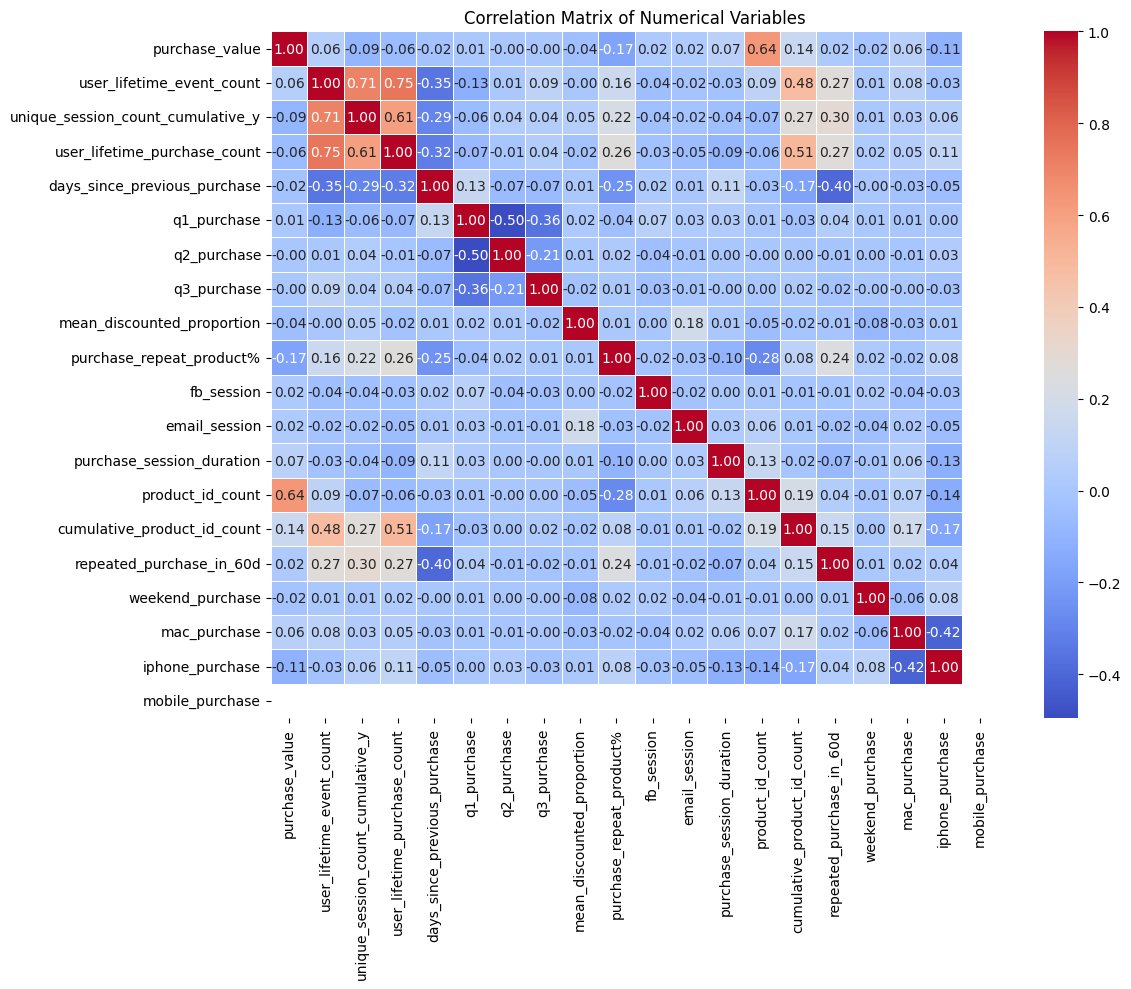

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = data.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Variables")
plt.tight_layout()
plt.show()

Categoric vs numeric variables

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
from scipy.stats import chi2_contingency

def mosaic_and_chi2_test(df, var, target='repeated_purchase_in_60d'):
    crosstab = pd.crosstab(df[var], df[target])
    data_dict = {(str(i), str(j)): crosstab.loc[i, j] for i in crosstab.index for j in crosstab.columns}

    color_map = {
        'True': '#40E0D0',
        'False': 'teal'
    }

    props = lambda key: {'color': color_map.get(str(key[1]), 'white')}

    plt.figure(figsize=(8, 6))
    mosaic(data_dict, properties=props, title=f'{var} vs {target}', gap=0.02)
    plt.show()

    chi2, p, _, _ = chi2_contingency(crosstab)
    return chi2, p


<Figure size 800x600 with 0 Axes>

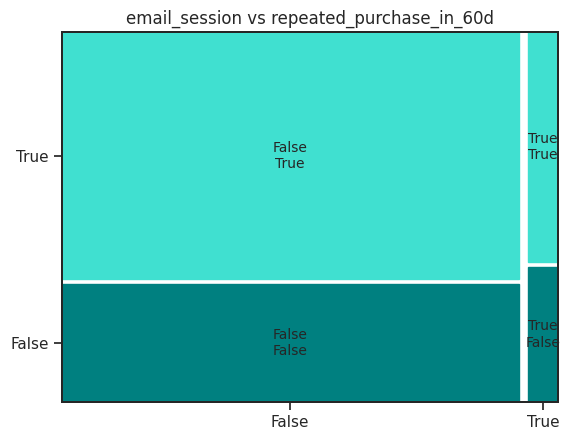


Variable: email_session
Chi2 = 11.4496, p-value = 0.0007


<Figure size 800x600 with 0 Axes>

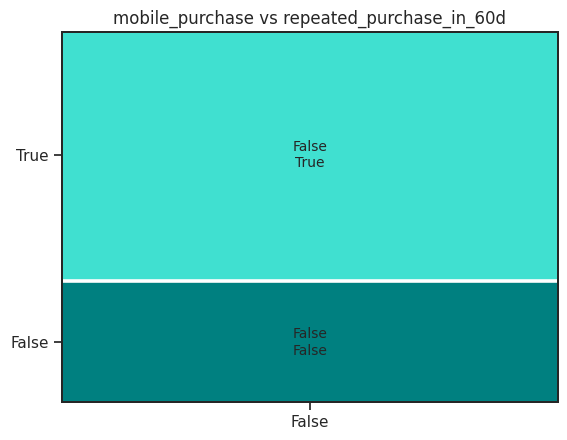


Variable: mobile_purchase
Chi2 = 0.0000, p-value = 1.0000


<Figure size 800x600 with 0 Axes>

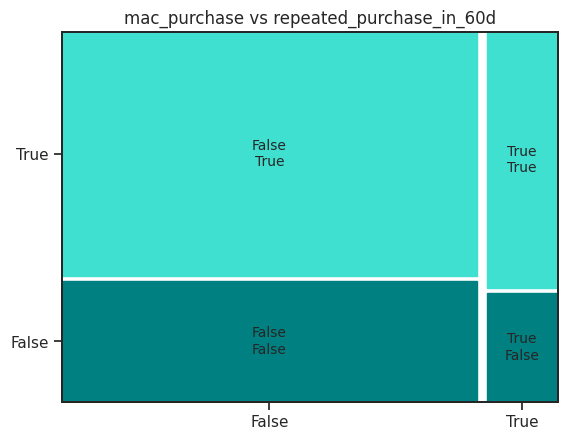


Variable: mac_purchase
Chi2 = 12.6167, p-value = 0.0004


<Figure size 800x600 with 0 Axes>

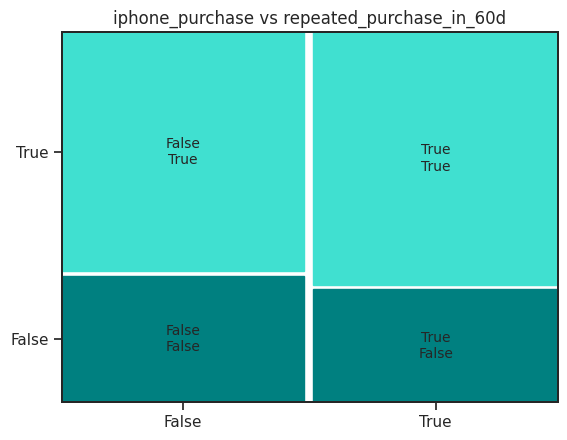


Variable: iphone_purchase
Chi2 = 32.2719, p-value = 0.0000


<Figure size 800x600 with 0 Axes>

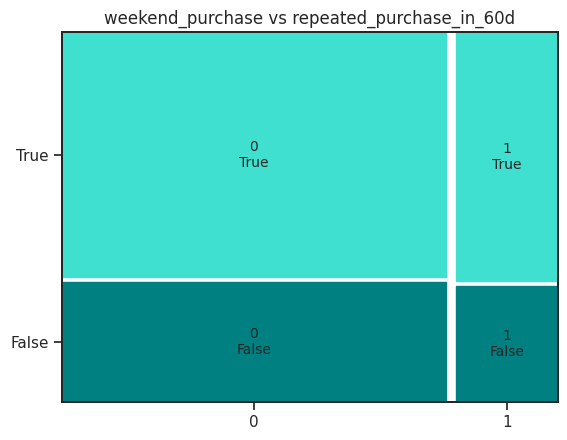


Variable: weekend_purchase
Chi2 = 2.1303, p-value = 0.1444


<Figure size 800x600 with 0 Axes>

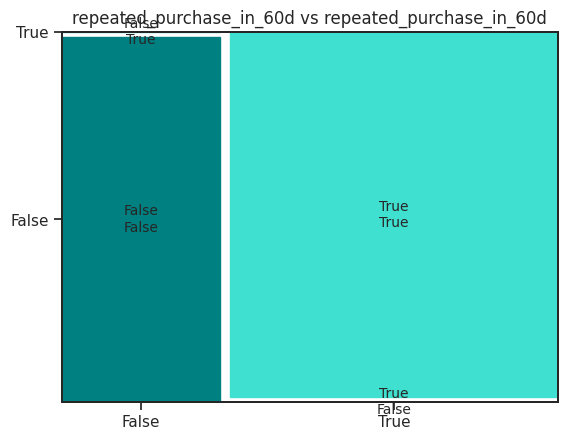


Variable: repeated_purchase_in_60d
Chi2 = 21433.4512, p-value = 0.0000


<Figure size 800x600 with 0 Axes>

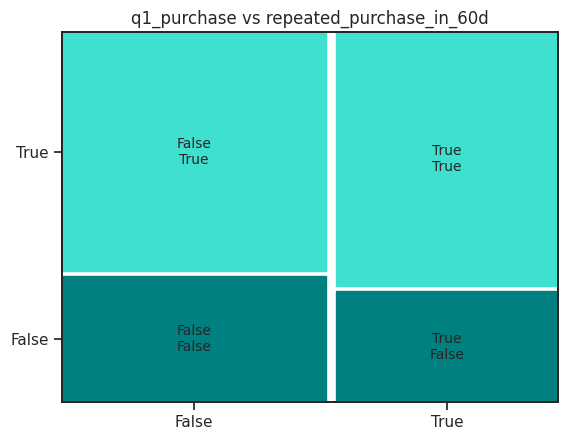


Variable: q1_purchase
Chi2 = 43.0599, p-value = 0.0000


<Figure size 800x600 with 0 Axes>

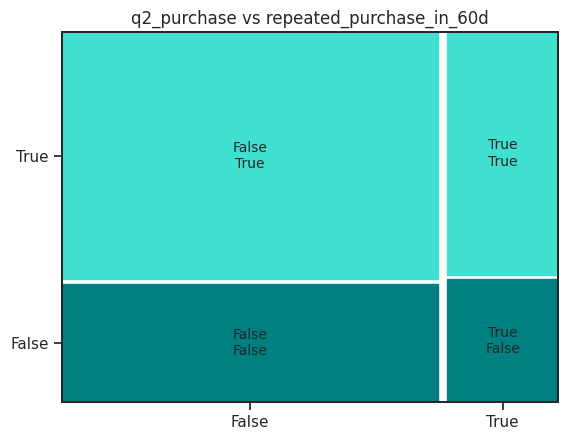


Variable: q2_purchase
Chi2 = 2.4578, p-value = 0.1169


<Figure size 800x600 with 0 Axes>

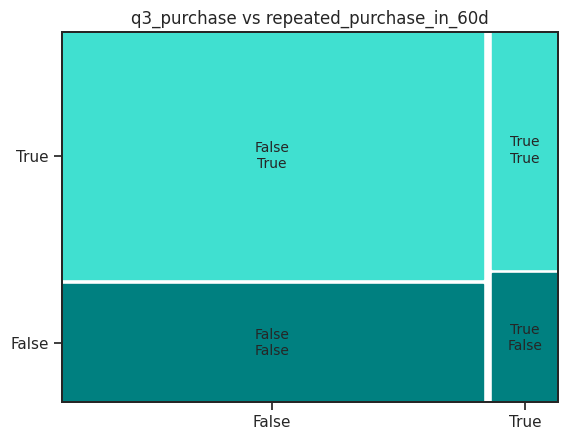


Variable: q3_purchase
Chi2 = 9.8405, p-value = 0.0017


In [20]:

results = {}

for var in categorical_variables:
    chi2, p = mosaic_and_chi2_test(data, var)
    results[var] = {'Chi2': chi2, 'p-value': p}
    print(f"\nVariable: {var}")
    print(f"Chi2 = {chi2:.4f}, p-value = {p:.4f}")

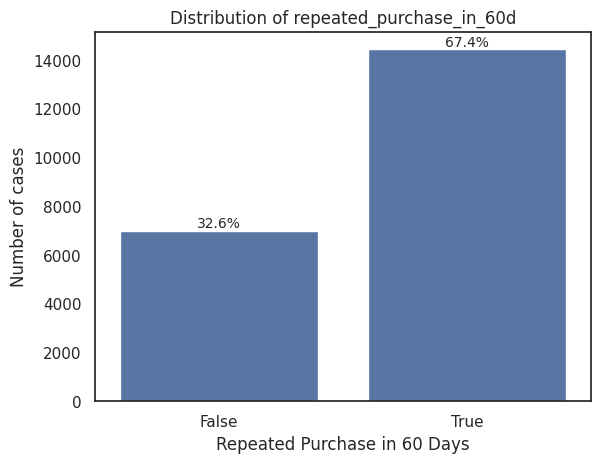

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.countplot(data=data, x='repeated_purchase_in_60d')

total = len(data)
for p in ax.patches:
    count = p.get_height()
    percentage = f'{100 * count / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=10)

plt.title('Distribution of repeated_purchase_in_60d')
plt.xlabel('Repeated Purchase in 60 Days')
plt.ylabel('Number of cases')
plt.show()


# **PREDICTIVE MODELS**

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

Recode categorical variables to 1 or 0 instead of True and False

In [24]:
data['repeated_purchase_in_60d'] = data['repeated_purchase_in_60d'].astype(int)

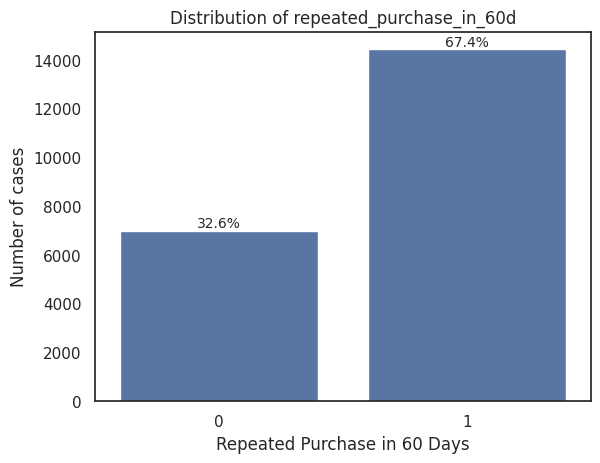

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.countplot(data=data, x='repeated_purchase_in_60d')

total = len(data)
for p in ax.patches:
    count = p.get_height()
    percentage = f'{100 * count / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=10)

plt.title('Distribution of repeated_purchase_in_60d')
plt.xlabel('Repeated Purchase in 60 Days')
plt.ylabel('Number of cases')
plt.show()


0 (False) is that they haven't bought again (CHURN) and 1 (True) that they have bought again (NO CHURN)



Now we need to divide the dataset into train and test sets to train and validate the model. In this case, we use 80% to train and 20% to test. The train set will have the target variable (repeat_purchase_within_60d) and the test set will not.


In [26]:
X = data.drop(columns= ["repeated_purchase_in_60d"])
y = data["repeated_purchase_in_60d"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN


smote_enn = SMOTEENN(random_state=42)
X_train, y_train = smote_enn.fit_resample(X_train, y_train)

In [28]:
train_dist = y_train.value_counts(normalize=True) * 100
print("Distribution of classes in y_train:")
print(train_dist.to_string(), "\n")

test_dist = y_test.value_counts(normalize=True) * 100
print("Distribution of classes in y_test:")
print(test_dist.to_string())

Distribution of classes in y_train:
repeated_purchase_in_60d
0    54.207783
1    45.792217 

Distribution of classes in y_test:
repeated_purchase_in_60d
1    66.347948
0    33.652052


In [29]:
from sklearn.feature_selection import mutual_info_classif, SelectKBest, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [30]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
import numpy as np

mi_scores = mutual_info_classif(X_train, y_train, random_state=42)
mi_series = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)

mi_cumsum = mi_series.cumsum()
mi_total = mi_series.sum()
mi_threshold = 0.9 * mi_total
selected_features = mi_cumsum[mi_cumsum <= mi_threshold].index.tolist()

if mi_cumsum[selected_features[-1]] < mi_threshold:
    next_feature = mi_cumsum[mi_cumsum > mi_threshold].index[0]
    selected_features.append(next_feature)

print(f"Selected {len(selected_features)} variables that explains the 90% of the dependence with the target variable:")
print(selected_features)

X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]


Selected 7 variables that explains the 90% of the dependence with the target variable:
['unique_session_count_cumulative_y', 'user_lifetime_purchase_count', 'days_since_previous_purchase', 'user_lifetime_event_count', 'purchase_value', 'cumulative_product_id_count', 'purchase_repeat_product%']


**RANDOM FOREST**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import numpy as np

param_grid = {
    'n_estimators': [200, 250, 500, 1000],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20],
    'bootstrap': [True, False]
}

rf_model = RandomForestClassifier(random_state=410)

grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_sel, y_train)

best_params_rf = grid_search.best_params_
print("\n Best hyperparameters:", best_params_rf)

best_model_rf = RandomForestClassifier(**best_params_rf, random_state=410)
best_model_rf.fit(X_train_sel, y_train)

y_proba_rf = best_model_rf.predict_proba(X_test_sel)[:, 1]



 Best hyperparameters: {'bootstrap': True, 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}


In [ ]:
import numpy as np
import pandas as pd

df = pd.DataFrame(y_proba_rf, columns=["probability"])
df.to_csv("probabilities_randomforest.csv", index=False)

In [ ]:
best_threshold = 0.5
best_precision = 0

for thresh in np.arange(0.8, 0.9, 0.01):
    y_pred_thresh = (y_proba_rf >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()

    specificity_rf = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    if  sensitivity >= 0.6 and specificity_rf > best_precision:
        best_precision_rf = specificity_rf
        best_threshold_rf = thresh

print(f"\n Best threshold: {best_threshold_rf:.2f} (Specificity = {best_precision_rf:.4f})")

y_pred_opt_rf = (y_proba_rf >= best_threshold_rf).astype(int)


 Best threshold: 0.70 (Specificity = 0.8621)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, roc_curve
)

conf_matrix_rf = confusion_matrix(y_test, y_pred_opt_rf)
categories = ['Churn', 'No churn']

conf_matrix_rf = pd.DataFrame(conf_matrix_rf, index=categories, columns=categories)

class_accuracy = np.diag(conf_matrix_rf) / np.sum(conf_matrix_rf, axis=1)
conf_matrix_rf['Accuracy'] = ["{:.2f}%".format(acc * 100) for acc in class_accuracy]

accuracy_rf = accuracy_score(y_test, y_pred_opt_rf)
precision_rf = precision_score(y_test, y_pred_opt_rf)
recall_rf = recall_score(y_test, y_pred_opt_rf)
f1_rf = f1_score(y_test, y_pred_opt_rf)
auc_rf = roc_auc_score(y_test, y_pred_opt_rf)


Matriz de confusión con precisión por clase:
          Churn  No churn Accuracy
Churn      1244       199   86.21%
No churn   1031      1814   63.76%

Métricas globales:
Accuracy:      0.7132
Precision:     0.9011
Recall:        0.6376
F1 Score:      0.7468
Specificity:   0.9369
AUC Score:     0.7499


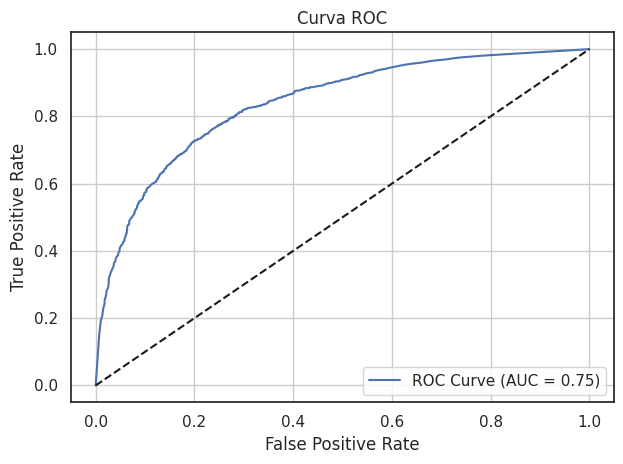

In [ ]:
print("\nMatriz de confusión con precisión por clase:")
print(conf_matrix_rf)

print("\nMétricas globales:")
print(f"Accuracy:      {accuracy_rf:.4f}")
print(f"Precision:     {precision_rf:.4f}")
print(f"Recall:        {recall_rf:.4f}")
print(f"F1 Score:      {f1_rf:.4f}")
print(f"Specificity:   {specificity_rf:.4f}")
print(f"AUC Score:     {auc_rf:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_proba_rf)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()



**LGBM Classifier**

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import numpy as np

param_grid = {
    'n_estimators': [150,200,500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5],
    'reg_lambda': [0.0, 0.1, 0.5]
}

lgbm_model = LGBMClassifier(random_state=410)

grid_search = GridSearchCV(lgbm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_sel, y_train)

best_params_lgbm = grid_search.best_params_
print("\nMejores hiperparámetros:", best_params_lgbm)

best_model_lgbm = LGBMClassifier(**best_params_lgbm, random_state=410)
best_model_lgbm.fit(X_train_sel, y_train)

y_proba_lgbm = best_model_lgbm.predict_proba(X_test_sel)[:, 1]

from sklearn.metrics import confusion_matrix, recall_score

[LightGBM] [Info] Number of positive: 4919, number of negative: 5823
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1328
[LightGBM] [Info] Number of data points in the train set: 10742, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.457922 -> initscore=-0.168710
[LightGBM] [Info] Start training from score -0.168710
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [ ]:
import numpy as np
import pandas as pd

df = pd.DataFrame(y_proba_lgbm, columns=["probability"])
df.to_csv("probabilities_lgbm.csv", index=False)

In [ ]:
best_threshold = 0.5
best_precision = 0

for thresh in np.arange(0.1, 0.9, 0.1):
    y_pred_thresh = (y_proba_lgbm >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()

    specificity_lgbm = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    if  sensitivity >= 0.6 and specificity_lgbm > best_precision:
        best_precision_lgbm = specificity_lgbm
        best_threshold_lgbm = thresh

print(f"\n Best threshold: {best_threshold_lgbm:.2f} (Specificity = {best_precision_lgbm:.4f})")

y_pred_opt_lgbm = (y_proba_lgbm >= best_threshold_lgbm).astype(int)


 Best threshold: 0.80 (Specificity = 0.8392)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

conf_matrix_lgbm = confusion_matrix(y_test, y_pred_opt_lgbm)
categories = ['Churn', 'No churn']


conf_matrix_lgbm = pd.DataFrame(conf_matrix_lgbm, index=categories, columns=categories)
class_accuracy = np.diag(conf_matrix_lgbm) / np.sum(conf_matrix_lgbm, axis=1)
class_accuracy_percentage = ["{:.2f}%".format(acc * 100) for acc in class_accuracy]
conf_matrix_lgbm['Accuracy'] = class_accuracy_percentage
conf_matrix_lgbm

,Churn,No churn,Accuracy
Churn,1211,232,83.92%
No churn,972,1873,65.83%


In [ ]:
accuracy_lgbm = accuracy_score(y_test, y_pred_opt_lgbm)
precision_lgbm = precision_score(y_test, y_pred_opt_lgbm)
recall_lgbm = recall_score(y_test, y_pred_opt_lgbm)
f1_lgbm = f1_score(y_test, y_pred_opt_lgbm)
auc_lgbm = roc_auc_score(y_test, y_proba_lgbm)

In [ ]:
from sklearn.metrics import roc_auc_score
print(conf_matrix_lgbm)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_opt_lgbm):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_opt_lgbm):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_opt_lgbm):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_opt_lgbm):.4f}")
print(f"Specificity:   {specificity_lgbm:.4f}")
print(f"AUC Score:  {roc_auc_score(y_test, y_proba_lgbm):.4f}")

          Churn  No churn Accuracy
Churn      1211       232   83.92%
No churn    972      1873   65.83%
Accuracy:  0.7192
Precision: 0.8898
Recall:    0.6583
F1 Score:  0.7568
Specificity:   0.8392
AUC Score:  0.8360


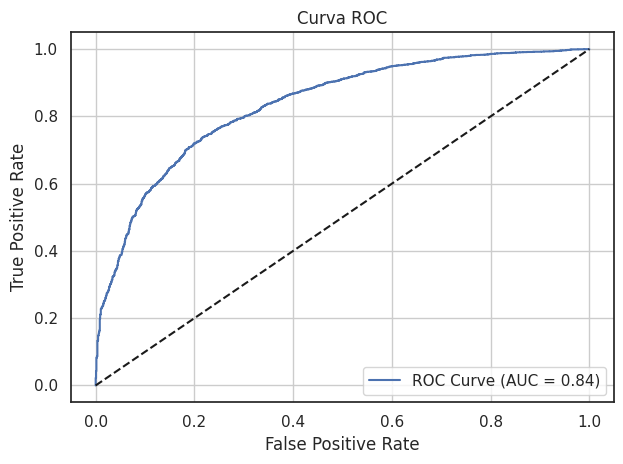

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba_lgbm)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_lgbm:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal (modelo aleatorio)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

**EXTRA TREES**

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import numpy as np

param_grid_et = {
    'n_estimators': [50, 100, 150, 200, 500],
    'max_depth': [None, 10, 20],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False],
}

et_model = ExtraTreesClassifier(random_state=410)
grid_search_et = GridSearchCV(et_model, param_grid_et, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_et.fit(X_train_sel, y_train)

best_params_et = grid_search_et.best_params_
print("\nMejores hiperparámetros:", best_params_et)

best_model_et = ExtraTreesClassifier(**best_params_et, random_state=410)
best_model_et.fit(X_train_sel, y_train)

y_proba_et = best_model_et.predict_proba(X_test_sel)[:, 1]

In [ ]:
import joblib
import gzip

with gzip.open('best_model_et.pkl.gz', 'wb') as f:
    joblib.dump(best_model_et, f)



In [ ]:
import pandas as pd

df = pd.DataFrame({
    "Probabilities": y_proba_et,
    "True_Label": y_test
})

df.to_csv("y_proba_et.csv", index=False)


In [ ]:
best_threshold = 0.5
best_precision = 0

for thresh in np.arange(0.6, 0.8, 0.01):
    y_pred_thresh = (y_proba_et >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()

    specificity_et = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    if  sensitivity >= 0.6 and specificity_et > best_precision:
        best_precision_et = specificity_et
        best_threshold_et = thresh

print(f"\n Best threshold: {best_threshold_et:.2f} (Specificity = {best_precision_et:.4f})")

y_pred_opt_et = (y_proba_et >= best_threshold_et).astype(int)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

conf_matrix_et = confusion_matrix(y_test, y_pred_opt_et)
categories = ['Churn', 'No churn']


conf_matrix_et = pd.DataFrame(conf_matrix_et, index=categories, columns=categories)
class_accuracy = np.diag(conf_matrix_et) / np.sum(conf_matrix_et, axis=1)
class_accuracy_percentage = ["{:.2f}%".format(acc * 100) for acc in class_accuracy]
conf_matrix_et['Accuracy'] = class_accuracy_percentage
conf_matrix_et

,Churn,No churn,Accuracy
Churn,1262,181,87.46%
No churn,1131,1714,60.25%


In [ ]:
accuracy_et = accuracy_score(y_test, y_pred_opt_et)
precision_et = precision_score(y_test, y_pred_opt_et)
recall_et = recall_score(y_test, y_pred_opt_et)
f1_et = f1_score(y_test, y_pred_opt_et)
auc_et = roc_auc_score(y_test, y_proba_et)

In [ ]:
print(conf_matrix_et)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_opt_et):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_opt_et):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_opt_et):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_opt_et):.4f}")
print(f"Specificity:   {specificity_et:.4f}")
print(f"AUC Score:  {roc_auc_score(y_test, y_proba_et):.4f}")

          Churn  No churn Accuracy
Churn      1262       181   87.46%
No churn   1131      1714   60.25%
Accuracy:  0.6940
Precision: 0.9045
Recall:    0.6025
F1 Score:  0.7232
Specificity:   0.9009
AUC Score:  0.8316


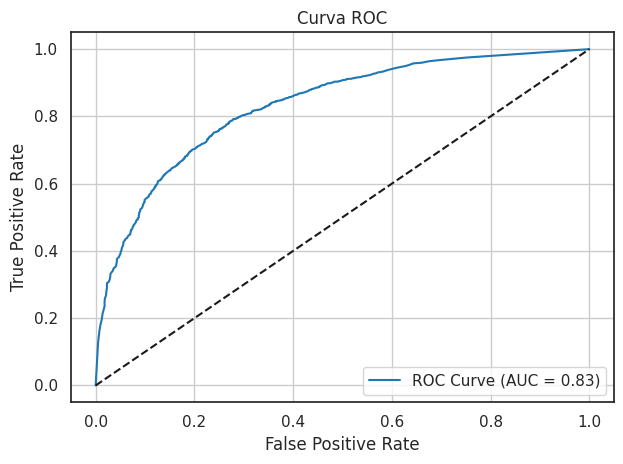

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba_et)

plt.figure()
plt.plot(fpr, tpr, color="#1f77b4", label=f'ROC Curve (AUC = {auc_et:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

**BAGGING**

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import numpy as np

base_tree = DecisionTreeClassifier()
bagging_model = BaggingClassifier(estimator=base_tree, random_state=410)

param_grid = {
    'n_estimators': [50, 100, 150, 200, 500],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

grid_search = GridSearchCV(bagging_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_sel, y_train)

best_params_bg = grid_search.best_params_
print("\nMejores hiperparámetros:", best_params_bg)

best_model_bg = BaggingClassifier(estimator=DecisionTreeClassifier(), **best_params_bg, random_state=410)
best_model_bg.fit(X_train_sel, y_train)

y_proba_bg = best_model_bg.predict_proba(X_test_sel)[:, 1]



Mejores hiperparámetros: {'bootstrap': False, 'bootstrap_features': False, 'max_features': 0.7, 'max_samples': 1.0, 'n_estimators': 500}


In [ ]:
import numpy as np
import pandas as pd

df = pd.DataFrame(y_proba_bg, columns=["probability"])
df.to_csv("probabilities_bagging.csv", index=False)

In [ ]:
best_threshold = 0.5
best_precision = 0

for thresh in np.arange(0.5, 0.7, 0.01):
    y_pred_thresh = (y_proba_bg >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()

    specificity_bg = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    if  sensitivity >= 0.6 and specificity_bg > best_precision:
        best_precision_bg = specificity_bg
        best_threshold_bg = thresh

print(f"\n Best threshold: {best_threshold_bg:.2f} (Specificity = {best_precision_bg:.4f})")

y_pred_opt_bg = (y_proba_bg >= best_threshold_bg).astype(int)


 Best threshold: 0.68 (Specificity = 0.8593)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

conf_matrix_bg = confusion_matrix(y_test, y_pred_opt_bg)
categories = ['Churn', 'No churn']


conf_matrix_bg = pd.DataFrame(conf_matrix_bg, index=categories, columns=categories)
class_accuracy = np.diag(conf_matrix_bg) / np.sum(conf_matrix_bg, axis=1)
class_accuracy_percentage = ["{:.2f}%".format(acc * 100) for acc in class_accuracy]
conf_matrix_bg['Accuracy'] = class_accuracy_percentage
conf_matrix_bg

,Churn,No churn,Accuracy
Churn,1240,203,85.93%
No churn,1125,1720,60.46%


In [ ]:
accuracy_bg = accuracy_score(y_test, y_pred_opt_bg)
precision_bg = precision_score(y_test, y_pred_opt_bg)
recall_bg = recall_score(y_test, y_pred_opt_bg)
f1_bg = f1_score(y_test, y_pred_opt_bg)
auc_bg = roc_auc_score(y_test, y_proba_bg)

In [ ]:
print(conf_matrix_bg)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_opt_bg):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_opt_bg):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_opt_bg):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_opt_bg):.4f}")
print(f"Specificity:   {specificity_bg:.4f}")
print(f"AUC Score:  {roc_auc_score(y_test, y_proba_bg):.4f}")

          Churn  No churn Accuracy
Churn      1240       203   85.93%
No churn   1125      1720   60.46%
Accuracy:  0.6903
Precision: 0.8944
Recall:    0.6046
F1 Score:  0.7215
Specificity:   0.8649
AUC Score:  0.8183


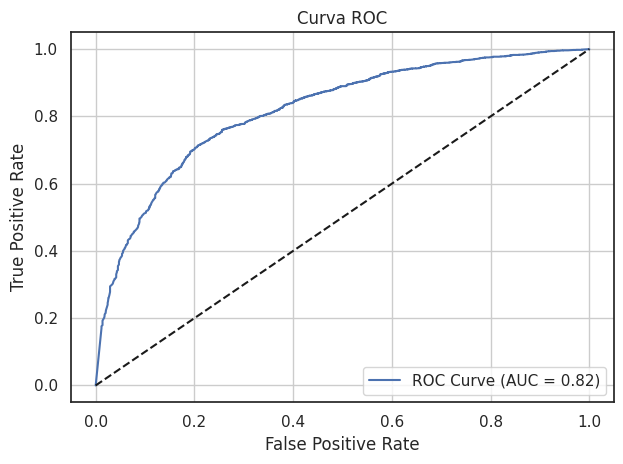

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba_bg)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_bg:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

**DECISION TREE**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [None, 5, 10, 15,20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 5, 10, 20]
}

dt_model = DecisionTreeClassifier(random_state=410)
grid_search = GridSearchCV(dt_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_sel, y_train)

best_params_dt = grid_search.best_params_
print("\nMejores hiperparámetros:", best_params_dt)

best_model_dt = DecisionTreeClassifier(**best_params_dt, random_state=410)
best_model_dt.fit(X_train_sel, y_train)

from sklearn.metrics import f1_score

y_proba_dt = best_model_dt.predict_proba(X_test_sel)[:, 1]


Mejores hiperparámetros: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 10}


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
1800 fits failed out of a total of 5400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
686 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ut

In [ ]:
import numpy as np
import pandas as pd

df = pd.DataFrame(y_proba_dt, columns=["probability"])
df.to_csv("probabilities_decisiontree.csv", index=False)

In [ ]:

best_threshold = 0.5
best_precision = 0

for thresh in np.arange(0.7, 0.9, 0.01):
    y_pred_thresh = (y_proba_dt >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()

    specificity_dt = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    if  sensitivity >= 0.6 and specificity_dt > best_precision:
        best_precision_dt = specificity_dt
        best_threshold_dt = thresh

print(f"\n Best threshold: {best_threshold_dt:.2f} (Specificity = {best_precision_dt:.4f})")

y_pred_opt_dt = (y_proba_dt >= best_threshold_dt).astype(int)


 Best threshold: 0.88 (Specificity = 0.8475)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, roc_curve
)


conf_matrix_dt = confusion_matrix(y_test, y_pred_opt_dt)
categories = ['Churn', 'No Churn']
conf_matrix_dt = pd.DataFrame(conf_matrix_dt, index=categories, columns=categories)

class_accuracy = np.diag(conf_matrix_dt) / np.sum(conf_matrix_dt, axis=1)
conf_matrix_dt['Accuracy'] = ["{:.2f}%".format(acc * 100) for acc in class_accuracy]

accuracy_dt = accuracy_score(y_test, y_pred_opt_dt)
precision_dt = precision_score(y_test, y_pred_opt_dt)
recall_dt = recall_score(y_test, y_pred_opt_dt)
f1_dt = f1_score(y_test, y_pred_opt_dt)
auc_dt = roc_auc_score(y_test, y_proba_dt)


Matriz de confusión con precisión por clase:
          Churn  No Churn Accuracy
Churn      1223       220   84.75%
No Churn   1113      1732   60.88%

Métricas globales:
Accuracy:  0.6891
Precision: 0.8873
Recall:    0.6088
F1 Score:  0.7221
Specificity:   0.8565
AUC Score: 0.7865


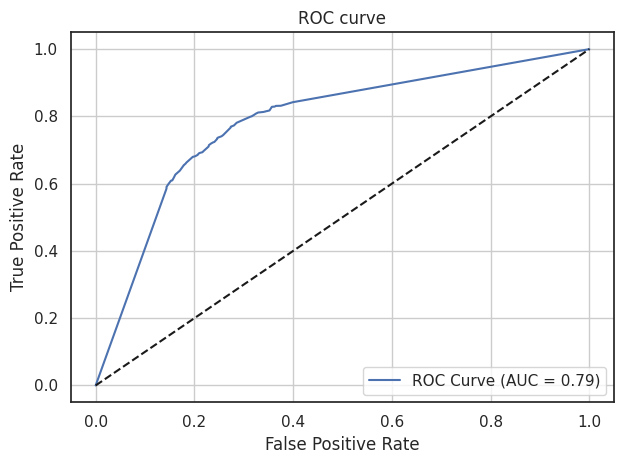

In [ ]:
print("\nMatriz de confusión con precisión por clase:")
print(conf_matrix_dt)

print("\nMétricas globales:")
print(f"Accuracy:  {accuracy_dt:.4f}")
print(f"Precision: {precision_dt:.4f}")
print(f"Recall:    {recall_dt:.4f}")
print(f"F1 Score:  {f1_dt:.4f}")
print(f"Specificity:   {specificity_dt:.4f}")
print(f"AUC Score: {auc_dt:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_proba_dt)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_dt:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

**ENSEMBLE**

In [ ]:
from collections import Counter

def voting_ensemble(*predictions):
    ensemble_predictions = []
    for instance_predictions in zip(*predictions):
        counts = Counter(instance_predictions)
        majority_vote = counts.most_common(1)[0][0]
        ensemble_predictions.append(majority_vote)
    return ensemble_predictions

ensemble_predictions = voting_ensemble(
    y_pred_opt_lgbm,
    y_pred_opt_et,
    y_pred_opt_bg,
    y_pred_opt_dt,
    y_pred_opt_rf
)



In [ ]:
def weighted_voting_ensemble(predictions, weights=None):
    from collections import Counter
    ensemble_predictions = []
    n_models = len(predictions)
    weights = weights if weights else [1] * n_models

    for instance_preds in zip(*predictions):
        weighted_votes = []
        for pred, weight in zip(instance_preds, weights):
            weighted_votes.extend([pred] * weight)
        majority_vote = Counter(weighted_votes).most_common(1)[0][0]
        ensemble_predictions.append(majority_vote)
    return ensemble_predictions

ensemble_predictions = weighted_voting_ensemble(
    [y_pred_opt_lgbm, y_pred_opt_et, y_pred_opt_bg, y_pred_opt_dt],
    weights=[2, 2, 1, 1]
)


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

y_ensemble = np.array(ensemble_predictions)

tn, fp, fn, tp = confusion_matrix(y_test, y_ensemble).ravel()

categories = ['Churn', 'No Churn']
conf_matrix_ensemble = confusion_matrix(y_test, y_ensemble)
conf_matrix_ensemble = pd.DataFrame(conf_matrix_ensemble, index=categories, columns=categories)

tn, fp, fn, tp = confusion_matrix(y_test, y_ensemble).ravel()

accuracy_ensemble = accuracy_score(y_test, y_ensemble)
precision_ensemble = precision_score(y_test, y_ensemble)
recall_ensemble = recall_score(y_test, y_ensemble)
f1_ensemble = f1_score(y_test, y_ensemble)
specificity_ensemble = tn / (tn + fp) if (tn + fp) != 0 else 0
y_proba_ensemble = (
    y_proba_lgbm +
    y_proba_et +
    y_proba_bg +
    y_proba_dt +
    y_proba_rf
) / 5


auc_ensemble = roc_auc_score(y_test, y_proba_ensemble)
print(conf_matrix_ensemble)

print(f"Accuracy:  {accuracy_ensemble:.4f}")
print(f"Precision: {precision_ensemble:.4f}")
print(f"Recall:    {recall_ensemble:.4f}")
print(f"F1 Score:  {f1_ensemble:.4f}")
print(f"Specificity:   {specificity_ensemble:.4f}")
print(f"AUC Score: {auc_ensemble:.4f}")


          Churn  No Churn
Churn      1240       203
No Churn   1031      1814
Accuracy:  0.7122
Precision: 0.8994
Recall:    0.6376
F1 Score:  0.7462
Specificity:   0.8593
AUC Score: 0.8347


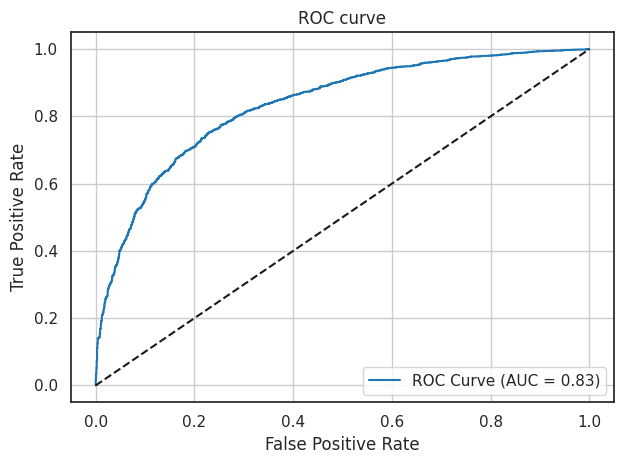

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba_ensemble)

plt.figure()
plt.plot(fpr, tpr, color='#1f77b4',label=f'ROC Curve (AUC = {auc_ensemble:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

**SHAP VALUES (explainability)**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import ExtraTreesClassifier

X = pd.DataFrame(X)

numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

et_classifier = ExtraTreesClassifier(random_state=42)

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', et_classifier)
])

model_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['purchase_value', 'user_lifetime_event_count',
       'unique_session_count_cumulative_y', 'user_lifetime_purchase_count',
       'days_since_previous_purchase', 'mean_discounted_proportion',
       'purchase...product%', 'purchase_session_duration',
       'product_id_count', 'cumulative_product_id_count', 'weekend_purchase'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('classifier', ExtraTreesClassifier(random_state=42))])

In [ ]:
from sklearn.metrics import classification_report

y_pred = model_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.61      0.67      1443
           1       0.82      0.89      0.85      2845

    accuracy                           0.79      4288
   macro avg       0.77      0.75      0.76      4288
weighted avg       0.79      0.79      0.79      4288



In [ ]:
import shap
explainer = shap.Explainer(model_pipeline.named_steps['classifier'])

In [ ]:
X_test_encoded = pd.get_dummies(X_test)
X_test_encoded

,purchase_value,user_lifetime_event_count,unique_session_count_cumulative_y,user_lifetime_purchase_count,days_since_previous_purchase,q1_purchase,q2_purchase,q3_purchase,mean_discounted_proportion,purchase_repeat_product%,fb_session,email_session,purchase_session_duration,product_id_count,cumulative_product_id_count,weekend_purchase,mac_purchase,iphone_purchase,mobile_purchase
7477,177600,530,42,19,5,True,False,False,1,0,False,False,1017,8,8,0,False,True,False
8268,136800,164,25,5,16,False,False,True,0,0,False,False,650,7,35,0,False,False,False
2036,114900,602,72,11,56,True,False,False,0,0,False,False,561,5,5,1,False,False,False
2789,292900,259,9,4,29,False,False,True,0,0,False,False,1072,9,32,1,False,False,False
15098,93594,244,46,22,28,True,False,False,0,1,False,False,660,3,6,1,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3745,198700,791,71,17,7,True,False,False,0,0,False,False,662,9,22,0,False,False,False
23662,269716,15,11,1,999,True,False,False,0,0,True,False,2909,11,11,0,False,False,False
20261,63200,61,9,1,999,False,True,False,0,0,False,False,2700,5,5,0,False,False,False
18934,127500,574,50,20,42,False,False,True,0,0,False,False,941,7,7,1,False,False,False


In [ ]:
shap_values.shape

(4288, 19, 2)

In [ ]:
shap_values = explainer.shap_values(X_test_encoded)
print(shap_values)

[[[ 0.0001844  -0.0001844 ]
  [ 0.08334425 -0.08334425]
  [-0.12926029  0.12926029]
  ...
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[-0.00348323  0.00348323]
  [ 0.09021546 -0.09021546]
  [-0.12809155  0.12809155]
  ...
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[-0.00160329  0.00160329]
  [ 0.08182804 -0.08182804]
  [-0.13092141  0.13092141]
  ...
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 ...

 [[-0.00247876  0.00247876]
  [ 0.09366608 -0.09366608]
  [-0.08690754  0.08690754]
  ...
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[-0.00274204  0.00274204]
  [ 0.08869693 -0.08869693]
  [-0.12681921  0.12681921]
  ...
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.00312388 -0.00312388]
  [ 0.07836134 -0.07836134]
  [-0.14234853  0.14234853]
  ...
  [ 0.          0.      

In [ ]:
import numpy as np

categorias_unicas = np.unique(y)
nombre_categoria = categorias_unicas[0]
print("Nombre de la categoría:", nombre_categoria)


Nombre de la categoría: 0


Positive class (No churn)

<ipython-input-154-e69f3f0a55d5>:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, 1], X_test)


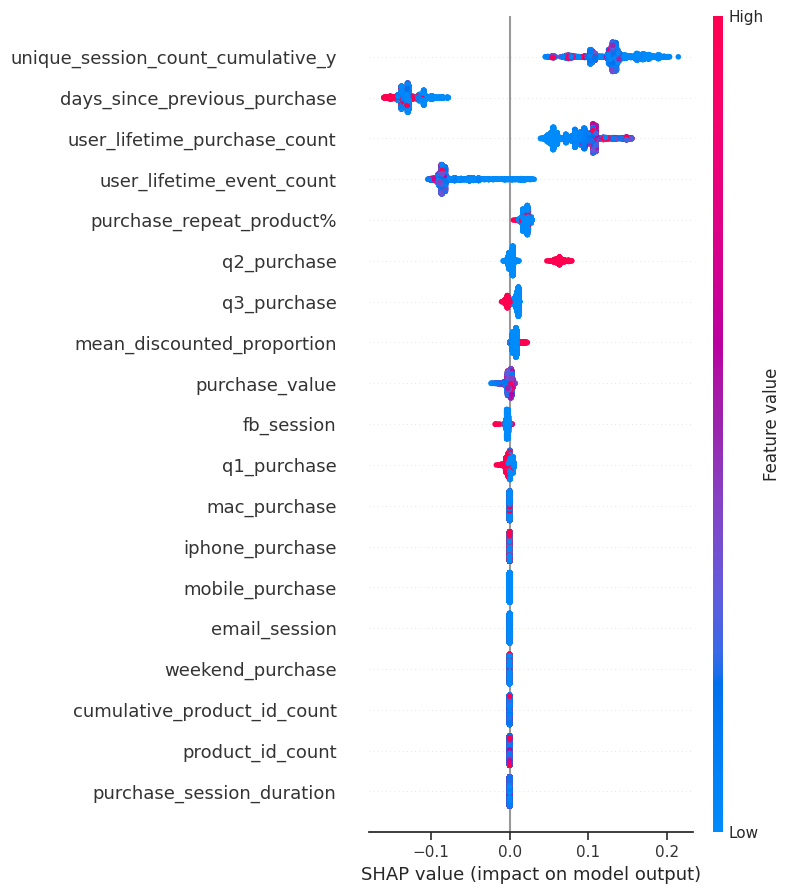

In [ ]:
shap.summary_plot(shap_values[:, :, 1], X_test)

Classe negativa (churn)

<ipython-input-159-9b2146c1bcf6>:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, 0], X_test)


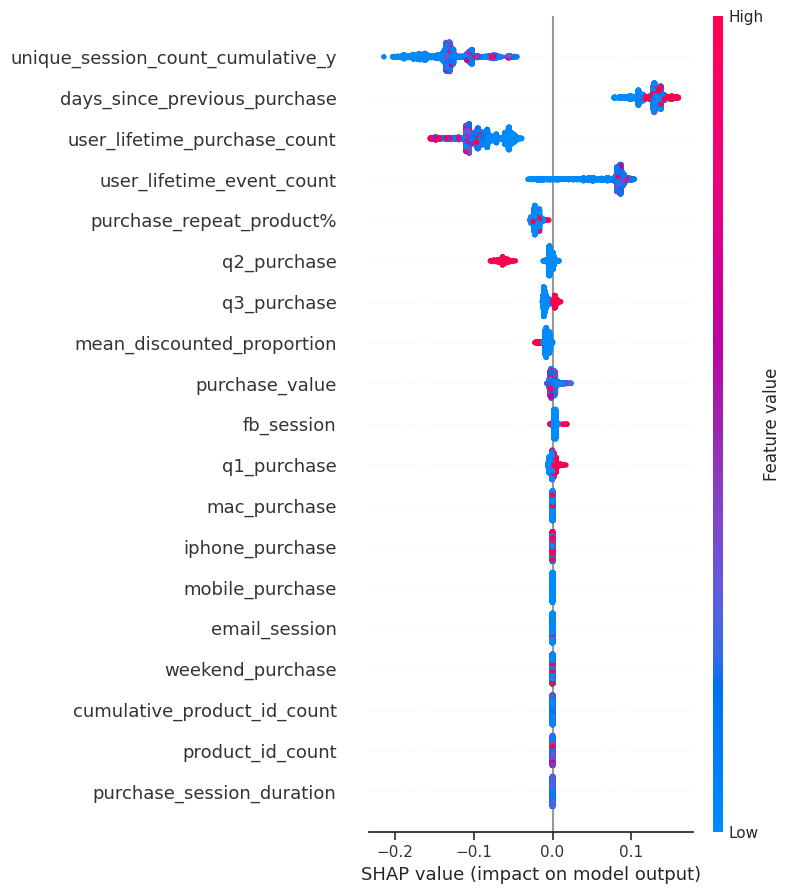

In [ ]:
shap.summary_plot(shap_values[:, :, 0], X_test)